In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score, davies_bouldin_score
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [73]:
X_train = pd.read_csv("preprocessing_data.csv")

In [ ]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

## Reduce dimensionality

### PCA

In [75]:
pca = PCA(n_components=0.90, random_state=123)
X_train_pca = pca.fit_transform(X_train)

In [76]:
X_train_pca.shape

(400, 207)

In [77]:
n_cluster_range = range(2, 21)

silhouette_scores = []

for n_clusters in n_cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=123, n_init=50, init='k-means++')
    kmeans.fit(X_train_pca)
    
    silhouette_avg = silhouette_score(X_train_pca, kmeans.labels_, random_state=123)
    silhouette_scores.append(silhouette_avg)
    
best_n_clusters = n_cluster_range[np.argmax(silhouette_scores)]

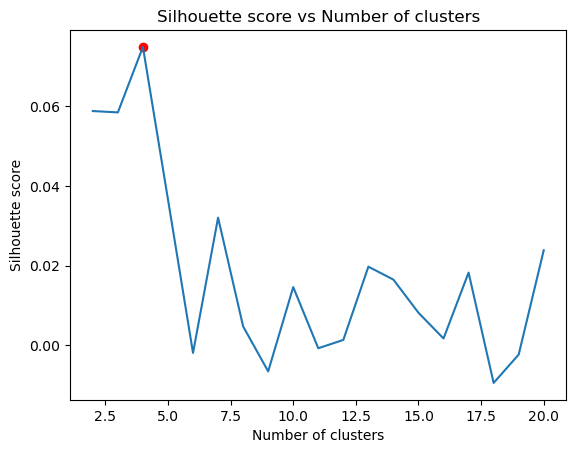

Best number of clusters: 4


In [78]:
plt.plot(n_cluster_range, silhouette_scores)
plt.scatter(best_n_clusters, max(silhouette_scores), color='red', label='Best number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs Number of clusters')
plt.show()

print(f'Best number of clusters: {best_n_clusters}')

In [79]:
kmeans_pca = KMeans(n_clusters=best_n_clusters, random_state=123, max_iter=1000, n_init=50, init='k-means++')
kmeans_pca.fit(X_train_pca)
kmeans_labels_pca = kmeans_pca.predict(X_train_pca)

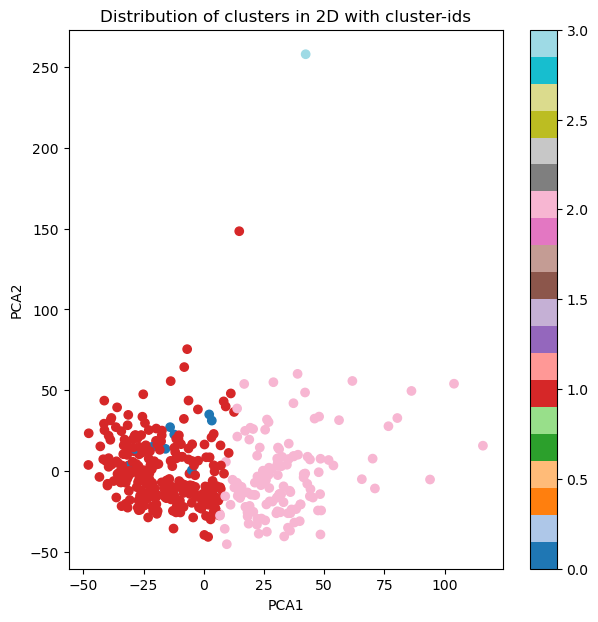

In [80]:
# Plot the distribution of clusters in 2D with their cluster-ids
plt.figure(figsize=(7, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_labels_pca, cmap='tab20')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Distribution of clusters in 2D with cluster-ids')
plt.colorbar()
plt.show()

In [81]:
print(f'Silhouette score: {silhouette_score(X_train_pca, kmeans_labels_pca)}')
print(f'Davies Bouldin score: {davies_bouldin_score(X_train_pca, kmeans_labels_pca)}')

Silhouette score: 0.07494084603873982
Davies Bouldin score: 2.639232010996141


Counter({1: 253, 2: 137, 0: 9, 3: 1})


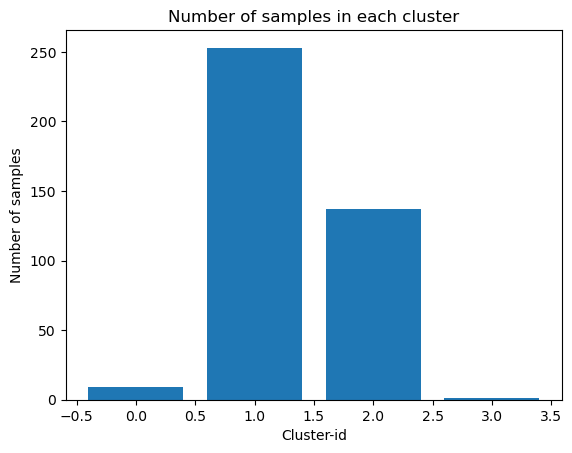

In [82]:
print(Counter(kmeans_labels_pca))

plt.bar(Counter(kmeans_labels_pca).keys(), Counter(kmeans_labels_pca).values())
plt.xlabel('Cluster-id')
plt.ylabel('Number of samples')
plt.title('Number of samples in each cluster')
plt.show()

In [83]:
import umap.umap_ as umap

In [84]:
pca_for_umap = PCA(n_components=0.99, random_state=123)
X_train_pca_umap = pca_for_umap.fit_transform(X_train)

umap_reducer = umap.UMAP(n_components=2, random_state=123)
X_train_umap = umap_reducer.fit_transform(X_train_pca_umap)

In [85]:
n_cluster_range = range(2, 21)

silhouette_scores = []

for n_clusters in n_cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=123, n_init=50, init='k-means++')
    kmeans.fit(X_train_umap)
    
    silhouette_avg = silhouette_score(X_train_umap, kmeans.labels_, random_state=123)
    silhouette_scores.append(silhouette_avg)
    
best_n_clusters = n_cluster_range[np.argmax(silhouette_scores)]

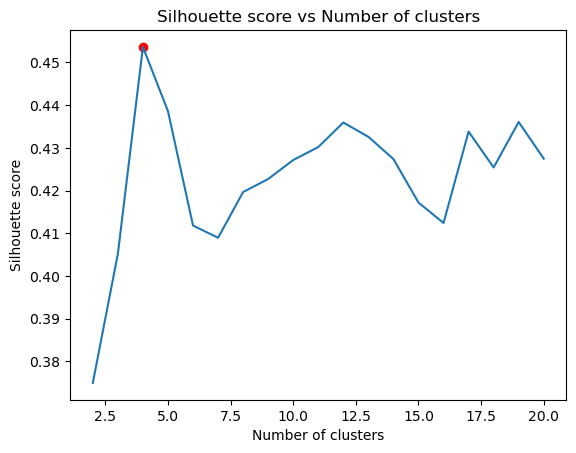

Best number of clusters: 4


In [86]:
plt.plot(n_cluster_range, silhouette_scores)
plt.scatter(best_n_clusters, max(silhouette_scores), color='red', label='Best number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs Number of clusters')
plt.show()

print(f'Best number of clusters: {best_n_clusters}')

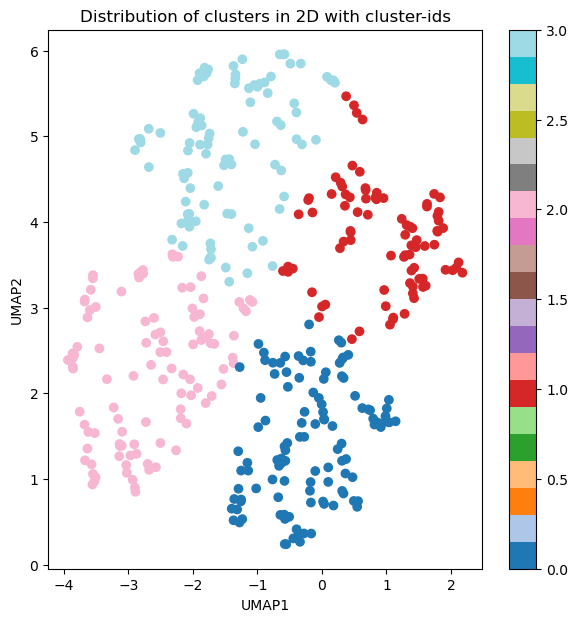

In [87]:
kmeans_umap = KMeans(n_clusters=best_n_clusters, random_state=123, max_iter=1000, n_init=50, init='k-means++')
kmeans_umap.fit(X_train_umap)
kmeans_labels_umap = kmeans_umap.predict(X_train_umap)

# Plot the distribution of clusters in 2D with their cluster-ids
plt.figure(figsize=(7, 7))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=kmeans_labels_umap, cmap='tab20')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('Distribution of clusters in 2D with cluster-ids')
plt.colorbar()
plt.show()

In [88]:
silhouette_score_train = silhouette_score(X_train_umap, kmeans_labels_umap)
davies_bouldin_score_train = davies_bouldin_score(X_train_umap, kmeans_labels_umap)

print(f'Silhouette score: {silhouette_score_train}')
print(f'Davies Bouldin score: {davies_bouldin_score_train}')

Silhouette score: 0.4536464810371399
Davies Bouldin score: 0.7235157038679125


Counter({0: 112, 2: 106, 3: 96, 1: 86})


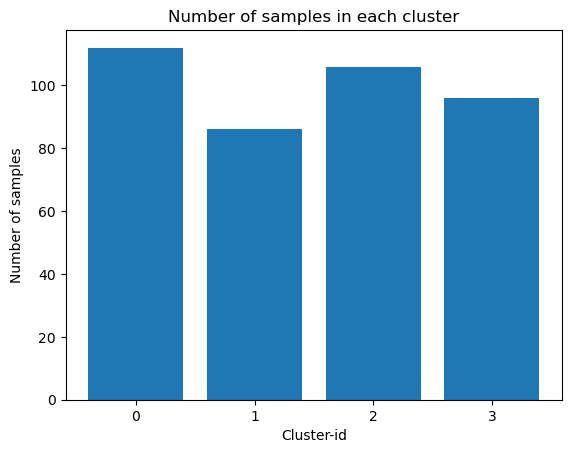

In [89]:
print(Counter(kmeans_labels_umap))

plt.bar(Counter(kmeans_labels_umap).keys(), Counter(kmeans_labels_umap).values())
plt.xlabel('Cluster-id')
plt.ylabel('Number of samples')
plt.title('Number of samples in each cluster')
plt.xticks(range(best_n_clusters))
plt.show()

In [90]:
X_val = pd.read_csv("umist_val_for_cluster.csv")
X_test = pd.read_csv("umist_test_for_cluster.csv")

In [91]:
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_val_pca = pca_for_umap.transform(X_val)
X_test_pca = pca_for_umap.transform(X_test)

In [92]:
X_val_umap = umap_reducer.transform(X_val_pca)
X_test_umap = umap_reducer.transform(X_test_pca)

In [93]:
kmeans_labels_val = kmeans_umap.predict(X_val_umap)
silhouette_score_val = silhouette_score(X_val_umap, kmeans_labels_val)
davies_bouldin_score_val = davies_bouldin_score(X_val_umap, kmeans_labels_val)
print(f'Silhouette score on validation set: {silhouette_score_val}')
print(f'Davies Bouldin score on validation set: {davies_bouldin_score_val}')

kmeans_labels_test = kmeans_umap.predict(X_test_umap)
silhouette_score_test = silhouette_score(X_test_umap, kmeans_labels_test)
davies_bouldin_score_test = davies_bouldin_score(X_test_umap, kmeans_labels_test)
print(f'Silhouette score on test set: {silhouette_score_test}')
print(f'Davies Bouldin score on test set: {davies_bouldin_score_test}')

Silhouette score on validation set: 0.3803791105747223
Davies Bouldin score on validation set: 0.8683964796345838
Silhouette score on test set: 0.39297056198120117
Davies Bouldin score on test set: 0.8113753725154341


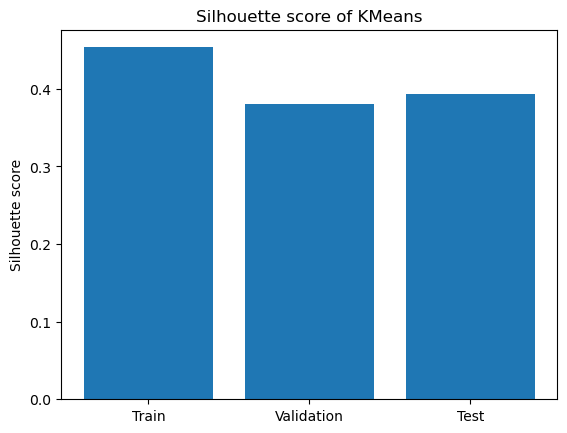

In [94]:
# plot of silhouette scores on train, validation and test sets 
plt.bar(['Train', 'Validation', 'Test'], [silhouette_score_train, silhouette_score_val, silhouette_score_test])
plt.ylabel('Silhouette score')
plt.title('Silhouette score of KMeans')
plt.show()

In [95]:
#umist_data = pd.read_csv("umist_cropped.csv")

In [96]:
# Add the cluster labels to the umist data
#umist_data['cluster_id'] = kmeans_labels_umap

# Save the data
#umist_data.to_csv('umist_cropped_kmeans_clustered.csv', index=False)